# Using NHL Regular Season Result Data to Predict Playoff Outcomes
### Trevor Garrood





In [ ]:
# Fetch From Kaggle
%sh
pip install kaggle
export KAGGLE_USERNAME=$USERNAME
export KAGGLE_KEY=$API_KEY
kaggle datasets download martinellis/nhl-game-data -p /mnt/NHL_Dataset
cd /mnt/NHL_Dataset
unzip nhl-game-data.zip
rm nhl-game-data.zip

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
import math

df = pd.read_csv('game_teams_stats.csv')
df1 = pd.read_csv('team_info.csv')
df2 = pd.read_csv('game.csv')

df = df.merge(df1, left_on='team_id', right_on='team_id')
df = df.merge(df2, left_on='game_id', right_on='game_id')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
""" Shows df1 """
df1.head()

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
2,26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
3,14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6


In [ ]:
""" Shows the df that has all game/score data """
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,...,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,...,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,...,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,...,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,...,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,...,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT


In [ ]:
def season_data_generator(season, team_abbv, df):
  """
  Takes in season year, team abbreviation, and the df
  Returns a dictionary with same headings as output
  """
  season_data = {}
  df_ploffs = df.copy()
  df = df[df['type'] == 'R']
  is_year = df['season'] == season
  is_team = df['abbreviation'] == team_abbv
  df_s = df[is_year & is_team]
  season_data['Season'] = season
  season_data['Team'] = team_abbv
  season_data['GF'] = df_s['goals'].sum()
  season_data['GA'] = (df_s['home_goals'].sum() + df_s['away_goals'].sum()) - season_data['GF']
  season_data['Total Season Wins'] = df_s.won.sum()
  highest_streak, num_streaks = get_win_streaks(df_s)
  season_data['Winstreaks'] = num_streaks
  season_data['Longest Win Streak'] = highest_streak
  season_data['Faceoff Percentage'] = round(df_s['faceOffWinPercentage'].mean(), 2)
  season_data['PIM'] = df_s['pim'].sum()
  season_data['Hits'] = df_s['hits'].sum()
  k = 2.15
  season_data['Win Ratio'] = round((season_data['GF'] ** k) / ((season_data['GA'] ** k) + (season_data['GF'] ** k)), 2)
  games_in_season = 82
  season_data['Expected Season Wins'] = round(season_data['Win Ratio'] * games_in_season, 2)

  df_ploffs = df_ploffs[df_ploffs['type'] == 'P']
  is_year = df_ploffs['season'] == season
  is_team = df_ploffs['abbreviation'] == team_abbv
  is_not_atl = df_ploffs['abbreviation'] != 'ATL'
  is_not_phx = df_ploffs['abbreviation'] != 'PHX'
  df_ploffs_s = df_ploffs[is_year & is_team & is_not_atl & is_not_phx]
  games_in_ploffs = 16
  season_data['Total Playoff Wins'] = df_ploffs_s.won.sum()
  season_data['Expected Playoff Wins'] =  round(season_data['Win Ratio'] * games_in_ploffs, 2)
  season_data['Playoff Round'] = int(round(season_data['Total Playoff Wins'] / 4))
  season_data['Total Games'] = df_s['won'].count() + df_ploffs_s['won'].count()
  return season_data

In [ ]:
def get_win_streaks(df):
  """
  Takes in a dataframe and returns the number of winstreaks
  and the length of the longest win streak
  """
  streaks = df['won'].groupby(df['won'].ne(df['won'].shift()).cumsum()).cumcount()
  highest_streak = streaks.max()
  num_streaks = len(streaks[streaks == 1])
  return highest_streak, num_streaks

In [ ]:
""" Tests output of season_data_generator """
season_data_generator(20182019, 'NJD', df)

{'Season': 20182019,
 'Team': 'NJD',
 'GF': np.float64(876.0),
 'GA': np.float64(1112.0),
 'Total Season Wins': np.int64(124),
 'Winstreaks': 41,
 'Longest Win Streak': 27,
 'Faceoff Percentage': np.float64(49.41),
 'PIM': np.float64(2980.0),
 'Hits': np.float64(7696.0),
 'Win Ratio': np.float64(0.37),
 'Expected Season Wins': np.float64(30.34),
 'Total Playoff Wins': np.int64(0),
 'Expected Playoff Wins': np.float64(5.92),
 'Playoff Round': 0,
 'Total Games': np.int64(328)}

In [ ]:
""" Tests output of season_data_generator
    with a team that makes the playoffs  """
season_data_generator(20182019, 'BOS', df)

{'Season': 20182019,
 'Team': 'BOS',
 'GF': np.float64(1028.0),
 'GA': np.float64(868.0),
 'Total Season Wins': np.int64(196),
 'Winstreaks': 39,
 'Longest Win Streak': 27,
 'Faceoff Percentage': np.float64(50.65),
 'PIM': np.float64(3188.0),
 'Hits': np.float64(7504.0),
 'Win Ratio': np.float64(0.59),
 'Expected Season Wins': np.float64(48.38),
 'Total Playoff Wins': np.int64(60),
 'Expected Playoff Wins': np.float64(9.44),
 'Playoff Round': 15,
 'Total Games': np.int64(424)}

In [ ]:
seasons = [20112012, 20132014, 20142015, 20152016, 20162017, 20172018, 20182019, 20192020]
def get_processed_data(seasons, df, df1):
  """
  where seasons is all seasons we have data for, df is the dataframe of all goals, wins, etc...
  and df1 is a dataframe of teams
  """
  team_data = []
  if type(seasons) is list:
    for season in seasons:
      for team in df1['abbreviation']:
        team_data.append(season_data_generator(season, team, df))
    df4 = pd.DataFrame(team_data).set_index('Team')
  elif type(seasons) is int:
    for team in df1['abbreviation']:
        team_data.append(season_data_generator(seasons, team, df))
    df4 = pd.DataFrame(team_data).set_index('Team')
  return df4

In [ ]:
df4 = get_processed_data(seasons, df, df1)
df4

<ipython-input-6-c7357e82d20a>:24: RuntimeWarning: invalid value encountered in scalar divide
  season_data['Win Ratio'] = round((season_data['GF'] ** k) / ((season_data['GA'] ** k) + (season_data['GF'] ** k)), 2)


,Season,GF,GA,Total Season Wins,Winstreaks,Longest Win Streak,Faceoff Percentage,PIM,Hits,Win Ratio,Expected Season Wins,Total Playoff Wins,Expected Playoff Wins,Playoff Round,Total Games
Team,,,,,,,,,,,,,,,
NJD,20112012,216.0,221.0,48,22,5.0,47.06,944.0,1677.0,0.49,40.18,14,7.84,4,106
PHI,20112012,260.0,236.0,47,23,5.0,48.30,1318.0,2058.0,0.55,45.10,5,8.80,1,93
LAK,20112012,188.0,185.0,40,22,5.0,51.49,923.0,2274.0,0.51,41.82,16,8.16,4,102
TBL,20112012,232.0,284.0,38,21,5.0,48.50,865.0,1788.0,0.39,31.98,0,6.24,0,82
BOS,20112012,260.0,211.0,49,19,7.0,54.60,1103.0,1778.0,0.61,50.02,3,9.76,1,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EDM,20192020,892.0,876.0,148,42,19.0,49.02,2308.0,6356.0,0.51,41.82,4,8.16,1,297
VGK,20192020,956.0,896.0,168,35,31.0,49.78,2360.0,8024.0,0.53,43.46,36,8.48,9,364
CAR,20192020,868.0,792.0,152,33,19.0,50.41,2352.0,4752.0,0.55,45.10,13,8.80,3,301


In [ ]:
def plot_and_analyze(x_col, y_col, df=df4):
  """
  Does some crazy shit
  """
  fig = plt.figure()
  # Plot
  sns.scatterplot(x=x_col, y=y_col, data=df, alpha=0.5, palette='muted')
  # R squared
  df = df.dropna()
  correlation_matrix = np.corrcoef(df[x_col], df[y_col])
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2
  print('R squared:')
  print(r_squared)
  # RMS error
  rms_error = math.sqrt(mean_squared_error(df[x_col], df[y_col]))
  print('RMS error:')
  print(rms_error)
  print()

R squared:
0.8908515009028389
RMS error:
2.965175231068713



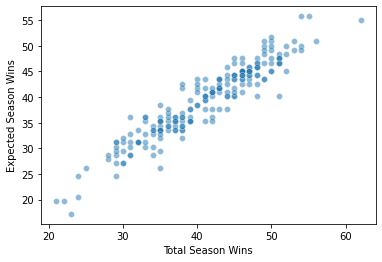

In [ ]:
# Plot Expected Season Wins vs. Total Season Wins
# fig = plt.figure(1)
# sns.scatterplot(x='Total Season Wins', y='Expected Season Wins', data=df4, alpha=0.5, palette="muted")
plot_and_analyze(x_col='Total Season Wins', y_col='Expected Season Wins')

In [ ]:
# Calculate R squared for Expected Season Wins vs. Total Season Wins
df4 = df4.dropna()
correlation_matrix = np.corrcoef(df4['Total Season Wins'], df4['Expected Season Wins'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

0.8908515009028389

In [ ]:
# Calculate RMS error for Expected Season Wins vs. Total Season Wins
df4 = df4.dropna()
rms_error = math.sqrt(mean_squared_error(df4['Total Season Wins'], df4['Expected Season Wins']))
rms_error

2.965175231068713

R squared:
0.013663499638670841
RMS error:
22.557369209648037



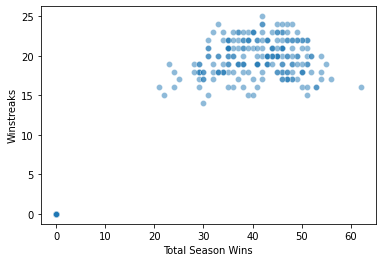

In [ ]:
plot_and_analyze(x_col='Total Season Wins', y_col="Winstreaks")

R squared:
0.05602743529630938
RMS error:
35.42764350797696



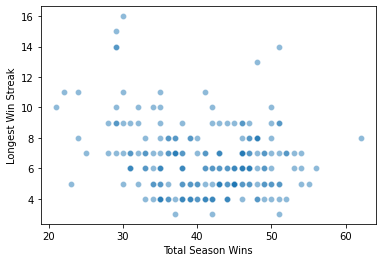

In [ ]:
plot_and_analyze(x_col='Total Season Wins', y_col="Longest Win Streak")

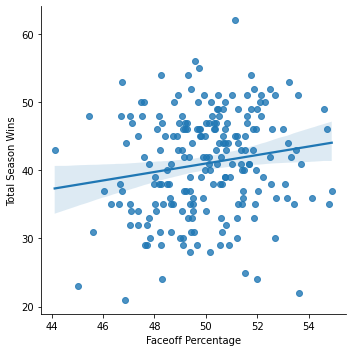

In [ ]:
# Plot Faceoff Percentage vs. Total Season Wins
# fig = plt.figure(3)
sns.lmplot(x='Faceoff Percentage', y='Total Season Wins', data=df4, palette="muted")

In [ ]:
# Calculate R squared for Faceoff Percentage vs. Total Season Wins
""" THIS IS VERY BAD """
df4 = df4.dropna()
correlation_matrix = np.corrcoef(df4['Faceoff Percentage'], df4['Total Season Wins'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

0.02674973312936811

In [ ]:
# Calculate RMS error for Faceoff Percentage vs. Total Season Wins
rms_error = math.sqrt(mean_squared_error(df4['Faceoff Percentage'], df4['Total Season Wins']))
rms_error

11.66690107356608

<ipython-input-5-c7357e82d20a>:24: RuntimeWarning: invalid value encountered in double_scalars
  season_data['Win Ratio'] = round((season_data['GF'] ** k) / ((season_data['GA'] ** k) + (season_data['GF'] ** k)), 2)


(20.0, 55.0)

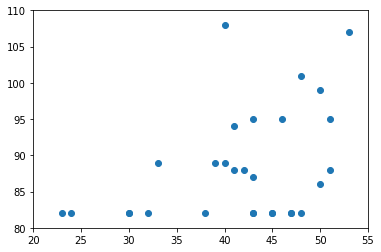

In [ ]:
# Plot Length of Previous Season vs. Performance the Next Season
# fig = plt.figure(6)
df5 = get_processed_data(20132014, df, df1)
df6 = get_processed_data(20142015, df, df1)
plt.scatter(df6['Total Season Wins'], df5['Total Games'])
plt.ylim(80,110)
plt.xlim(20, 55)

In [ ]:
# Calculate R squared for Length of Previous Season vs. Performance the Next Season
correlation_matrix = np.corrcoef(df6['Total Season Wins'], df5['Total Games'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

0.49774918764982057

In [ ]:
# Calculate RMS error for Length of Previous Season vs. Performance the Next Season
rms_error = math.sqrt(mean_squared_error(df6['Total Season Wins'], df5['Total Games']))
rms_error

47.0132154212241

In [ ]:
df = df4.copy()

df = df.loc[:, df.columns != 'Playoff Round']

features = df.loc[:, df.columns != 'Total Playoff Wins']
labels = df['Total Playoff Wins']

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=1)

# Create an untrained model
model = DecisionTreeClassifier(max_depth=7)

# Train it on the **training set**
model.fit(features_train, labels_train)

# Compute training accuracy
train_predictions = model.predict(features_train)
print('Train Accuracy:', accuracy_score(labels_train, train_predictions))

# Compute test accuracy
test_predictions = model.predict(features_test)
print('Test  Accuracy:', accuracy_score(labels_test, test_predictions))
print('Test predictions:', test_predictions)
print('Actual Results:', labels_test)

Train Accuracy: 0.972972972972973
Test  Accuracy: 0.84375
Test predictions: [ 7  2  0 11 14  0  0  2  7  5  2  3  7  0  0  5 11  3  3  6  0  3  4  0
  0 16  2 16  0  4  1 10  0  0  4  1  0  0  0  0  0  0  3  0  1  0  0  0
 11  7  2  2  0  0  2  0  0  0  0  0  0  0  0  2]
Actual Results: Team
MIN     6
NSH     2
FLA     0
TBL    11
NYR    13
       ..
OTT     0
NJD     0
NSH     0
EDM     0
CBJ     2
Name: Total Playoff Wins, Length: 64, dtype: int64


Index(['Season', 'GF', 'GA', 'Total Season Wins', 'Winstreaks',
       'Longest Win Streak', 'Faceoff Percentage', 'PIM', 'Hits', 'Win Ratio',
       'Expected Season Wins', 'Expected Playoff Wins', 'Total Games'],
      dtype='object')
Train Accuracy: 0.9723756906077348
Test  Accuracy: 0.8064516129032258


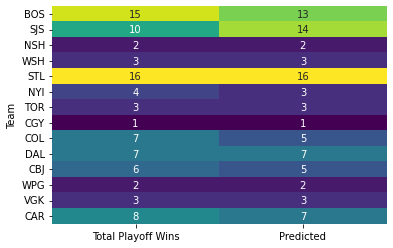

In [ ]:
df = df4.copy()
df1 = df4.copy()
df = df.loc[:, df.columns != 'Playoff Round']
df1 = df1.loc[:, df1.columns != 'Playoff Round']

df = df[df['Season'] != 20182019]
features_train = df.loc[:, df.columns != 'Total Playoff Wins']
labels_train = df['Total Playoff Wins']

df1 = df1[df1['Season'] == 20182019]
features_test = df1.loc[:, df1.columns != 'Total Playoff Wins']
labels_test = df1['Total Playoff Wins']
print(features_test.columns)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create an untrained model
model = DecisionTreeClassifier(max_depth=7)

# Train it on the **training set**
model.fit(features_train, labels_train)

# Compute training accuracy
train_predictions = model.predict(features_train)
print('Train Accuracy:', accuracy_score(labels_train, train_predictions))

# Compute test accuracy
test_predictions = model.predict(features_test)
print('Test  Accuracy:', accuracy_score(labels_test, test_predictions))
df_out = pd.DataFrame(labels_test)
df_out['Predicted'] = test_predictions
df_out = df_out.loc[~(df_out==0).all(axis=1)]
fig = plt.figure(facecolor='w', edgecolor='k')
sns.heatmap(df_out, annot=True, cmap='viridis', cbar=False)

*** Questions we are trying to answer ***


*   Can pythagorean expectation predict wins/performance?
*   Do regular season win streaks affect playoff performance?
*   How does playing a longer season affect performance the next year?
*   Can a team’s total number of wins, frequency/length of win streaks, and total number of goals scored be used to predict playoff outcomes?






*** To Do ***

*   Graph relationships of wins vs faceoff percent. Calc rms and R^2 for analysis too. Example shown with total vs expected wins
*   Graph relationships of win streaks vs performance
*   Figure out how to calculate performance. How do we want to do this? Power rankings? Playoff results? Idk
*   Build a machine learning thing? Idk






